# All imports

In [8]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string

import json

import tensorflow as tf
import numpy as np

# Preprocessing

In [9]:
# import nltk
# from nltk.stem.porter import PorterStemmer
# from nltk.corpus import stopwords
# import string


english_stopwords = set(stopwords.words('english'))
punctuation = set(string.punctuation)
punctuation.add("'s")


stemmer = PorterStemmer()

def stem(word):
    return stemmer.stem(word)

def tokenize(sentence):
    words = nltk.word_tokenize(sentence)
    words = [stem(w) for w in words if w.lower() not in english_stopwords and w not in punctuation]
    return words



def bag_of_words(pattern_sentences,all_words):
    bag = [1 if w in pattern_sentences else 0 for w in all_words]
    return bag

# Reading JSON File

In [10]:
import json
with open ('ECchatBotData.json','r') as f:
    intents = json.load(f) 

all_words = []
tags = []
xy = []

for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w,tag))

all_words = sorted(set(all_words))
tags = sorted(tags)

# AuroCorrecter

In [11]:
from autocorrect import Speller

# Initialize the spell checker
spell = Speller()

def correct_misspelled_words(sentence):
    # Split the sentence into words
    words = sentence.split()
    
    # Correct each word
    corrected_words = [spell(word) for word in words]
    
    # Join the corrected words back into a sentence
    corrected_sentence = ' '.join(corrected_words)
    
    return corrected_sentence



# Building dataset

In [12]:
x_train = []
y_train = []

for (pattern_sentences,tag) in xy:
    bag = bag_of_words(pattern_sentences,all_words)
    bag = np.array(bag,dtype=np.float32)
    x_train.append(bag)
    
    label = tags.index(tag)
    y_train.append(label)

# Creating model


In [13]:

x_train = np.array(x_train)
y_train = np.array(y_train)

# Create the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(len(all_words),)), 
    tf.keras.layers.Dense(132, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(len(tags), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 132)                 │          19,404 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 90)                  │          11,970 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 36)                  │           3,276 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,650 (135.35 KB)

 Trainable params: 34,650 (135.35 KB)

 Non-trainable params: 0 (0.00 B)

# Training Model

In [14]:
# Train the model
history = model.fit(x_train, y_train, epochs=60, batch_size=len(tags))

Epoch 1/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0022 - loss: 3.5943      
Epoch 2/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0629 - loss: 3.5295     
Epoch 3/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1668 - loss: 3.4783 
Epoch 4/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3563 - loss: 3.4105 
Epoch 5/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4961 - loss: 3.3445 
Epoch 6/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4739 - loss: 3.2738 
Epoch 7/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5510 - loss: 3.1462 
Epoch 8/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5465 - loss: 3.0452 
Epoch 9/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5476 - loss: 2.9325 
Epoch 10/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5538 - loss: 2.7597 
Epoch 11/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5545 - loss: 2.5631 
Epoch 12/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6129 - loss: 

# Saving Model

In [15]:
model.save('emo1.keras')

# Performance

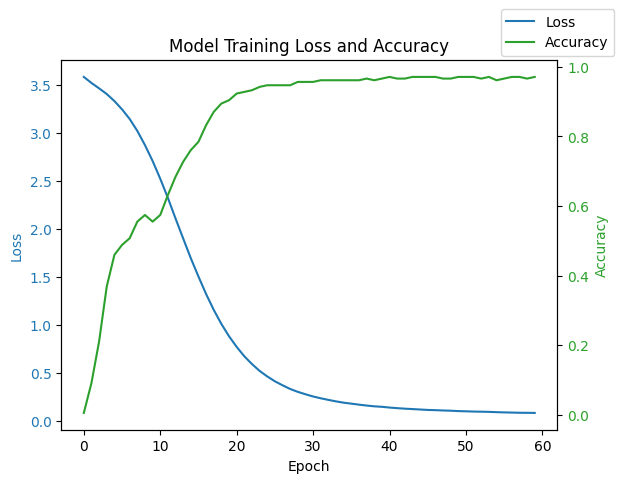

In [16]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()

# Plotting the loss
ax1.plot(history.history['loss'], color='tab:blue', label='Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot the accuracy
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], color='tab:green', label='Accuracy')
ax2.set_ylabel('Accuracy', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Adding a title
plt.title('Model Training Loss and Accuracy')

# Adding legends
fig.legend(loc='upper right', bbox_to_anchor=(1,1))

# Show the plot
plt.show()


# Loading Model

In [17]:
from tensorflow.keras.models import load_model
savedModel=load_model('emo1.keras')

# Response Function


In [18]:
# Create the response function
def get_response(input_sentence):
    # Preprocess the input sentence
    input_sentence = correct_misspelled_words(input_sentence)
    input_bag = bag_of_words(tokenize(input_sentence), all_words)
    input_bag = np.array(input_bag).reshape(1, -1)
    
    # Predict the intent
    predictions = savedModel.predict(input_bag)
    tag = tags[np.argmax(predictions)]
    
    max_prob_index = np.argmax(predictions)
    confidence = predictions[0][max_prob_index]
    
    # Get a random response for the predicted tag
    for intent in intents['intents']:
        if intent['tag'] == tag:
            responses = intent['responses']
            if confidence < 0.5:
                return confidence , "Sorry I did not Understand"
            else:
                return confidence ,np.random.choice(responses)

# Test

In [19]:
# Example usage
input_sentence = "Hi, how are you?"
response = get_response(input_sentence)
print(response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
(0.96480656, 'Hello there, what can I do for you?')


In [22]:
print(get_response("which size is best fit for me"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
(0.14984468, 'Sorry I did not Understand')


In [23]:
print(get_response("which size of men shirt is correct for me ?"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
(0.8055361, "Sure! Here is the size chart for men's shirts:\n\n- Small (S): Chest 34-36 inches\n- Medium (M): Chest 38-40 inches\n- Large (L): Chest 42-44 inches\n- Extra Large (XL): Chest 46-48 inches\n- Double Extra Large (XXL): Chest 50-52 inches")


In [25]:
print(get_response("I want some summer cloths"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
(0.9883382, "Check out our 'Summer Collection' for the latest summer outfits and trends.")


In [26]:
print(get_response("is there any discount going on"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
(0.88625807, "Check out our 'Discounts' page for the latest promotions and offers.")


In [27]:
print(get_response(" thanks for help"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
(0.91523874, "Glad I could help! If you need assistance in the future, don't hesitate to reach out. Have a wonderful day!")


In [28]:
print(get_response("how can I cancel my order"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
(0.98581856, 'You can cancel your order through the order history section in your account.')


In [29]:
print(get_response(" size for woman top"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
(0.9228708, "Sure! Here is the size chart for women's tops:\n\n- Extra Small (XS): Bust 31-32 inches, Waist 24-25 inches, Hips 33-34 inches\n- Small (S): Bust 33-34 inches, Waist 26-27 inches, Hips 35-36 inches\n- Medium (M): Bust 35-36 inches, Waist 28-29 inches, Hips 37-38 inches\n- Large (L): Bust 37-39 inches, Waist 30-31 inches, Hips 39-41 inches\n- Extra Large (XL): Bust 40-42 inches, Waist 32-34 inches, Hips 42-44 inches")
